<Body>   
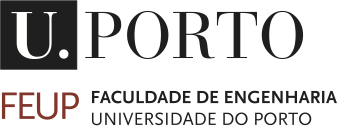   
<h1> <b>Machine Learning 2022/2023 (2<sup>nd</sup> semester) </b> </h1>
<p>Master in Electrical and Computer Engineering </p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  

**A. Pedro Aguiar** (pedro.aguiar@fe.up.pt),
**Aníbal Matos** (anibal@fe.up.pt),
**Daniel Costa** (danielgcosta@fe.up.pt),
**Rui Gonçalves** (rjpg@fe.up.pt)

FEUP, Feb. 2023

---


# **Project #02**

**Note:** This work is to be done in group of **2** elements. Use this notebook to answer all the questions. At the end of the work, you should **upload** the **notebook** and a **pdf file** with a printout of the notebook with all the results in the **moodle** platform.
To generate the pdf file we have first to covert the notebook to html using the command `!jupyter nbconvert --to html "ML_project2.ipynb"`, then open the html file and printout to PDF.

**Deadlines:** Present you work (and answer questions) on the week of **May 22** in your corresponding practical class. Upload the files until 23:59 of **June 2, 2023**.


---



# **Identification**

* **Group:** ProjectA05C
* **Name:** Carlos Thadeu Aguiar de Faria
* **Student Number:** 202202472

**Initial setup:** To download the data files, run the next cell.

In [1]:
!wget -O data-setMLproject2.zip https://www.dropbox.com/s/hnyhgqlj5lcqyqr/data-setMLproject2.zip?dl=0 --quiet
!unzip data-setMLproject2.zip -d.

Archive:  data-setMLproject2.zip
  inflating: ./data_test.csv         
  inflating: ./__MACOSX/._data_test.csv  
  inflating: ./data_test2obs.csv     
  inflating: ./__MACOSX/._data_test2obs.csv  
  inflating: ./data_train.csv        
  inflating: ./__MACOSX/._data_train.csv  


# **Main goal**

Consider the following scenario: A mobile robot aims to build a map of the environment with **semantics**, meaning that the robot should be capable to classify the objects nearby. The robot is travelling around and carries on-board a 2D LIDAR measurement device that obtains range measurements at each sample time $t=0, 0.1, 0.2, \ldots$ The following cell shows an example of the type of data:


In [2]:
import pandas as pd
df_test2obs = pd.read_csv('data_test2obs.csv', index_col=0)

Note that the LIDAR measurements consist of range (distance) from the robot to a possible obstacle for each degree of direction, that is, 
$$
r_t = \{r_\beta + \eta_r : \beta=-179^o, -178^o, \ldots, 0^o, \ldots, 180^o\}
$$
where $\eta_r$ is assumed to be Gaussian noise. If there is no obstacle within the direction of the laser range or if it is far away, that is, if the distance is greater than $5\,m$, by convention the range measurement is set to zero. Moreover, with a small probability, the range measurements could be corrupted with *outliers*.

The next figure shows $r_t$ as a function of the angle $\beta$ taken at time $t=1.0\,s$.


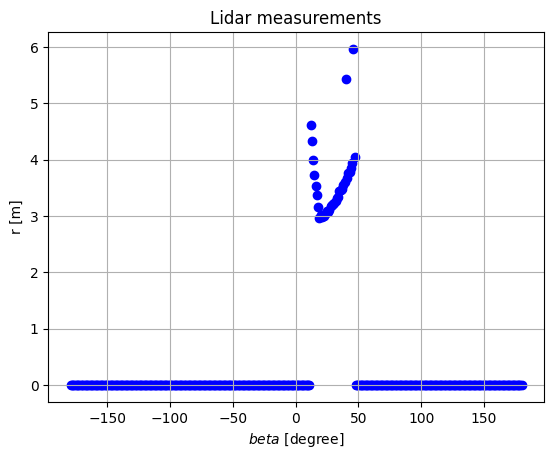

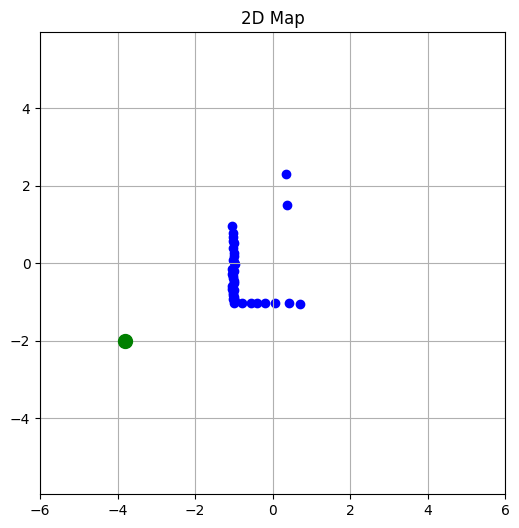

In [3]:
import numpy as np
from numpy import * 
import matplotlib.pyplot as plt

Lidar_range = df_test2obs.iloc[:, np.arange(2,362,1)].values
px = df_test2obs["px"].values
py = df_test2obs["py"].values

t=1*10 #1sec times number of samples/second
angle = np.linspace(-179, 180, num=360)

plt.figure()
plt.scatter(angle, Lidar_range[t], color='b')
plt.title('Lidar measurements')
plt.ylabel('r [m]')
plt.xlabel('$beta$ [degree]')
plt.grid();
plt.show()

#Build the cloud points in 2D plan
x_o, y_o = [], []
for i in range(len(Lidar_range[t])):
  if Lidar_range[t][i] > 0:
    x_o.append(px[t]+Lidar_range[t][i]*np.cos(angle[i]/180*np.pi))
    y_o.append(py[t]+Lidar_range[t][i]*np.sin(angle[i]/180*np.pi))

fig, ax = plt.subplots(figsize=(6,6))
ax.axis('equal')
xdim, ydim = 5, 5
plt.xlim(-xdim-1,xdim+1)
plt.ylim(-ydim-1,ydim+1)
plt.plot(px[t], py[t], 'g.', ms=20)  #position of the robot
plt.grid()

plt.scatter(x_o, y_o, color='b')
plt.title('2D Map');
plt.show()

Note that it may be possible to have more than one object in the range of the LIDAR. \\
Here goes an example when $t=32\,s$:


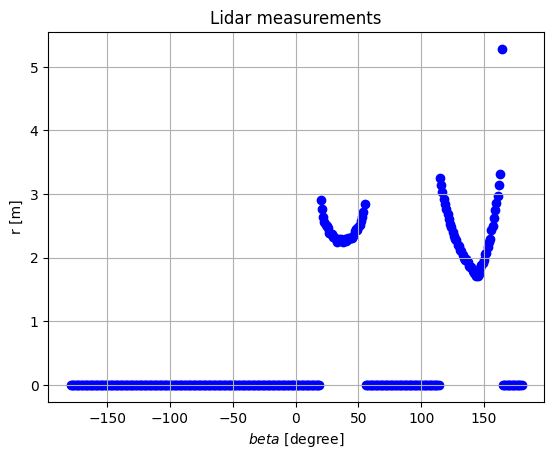

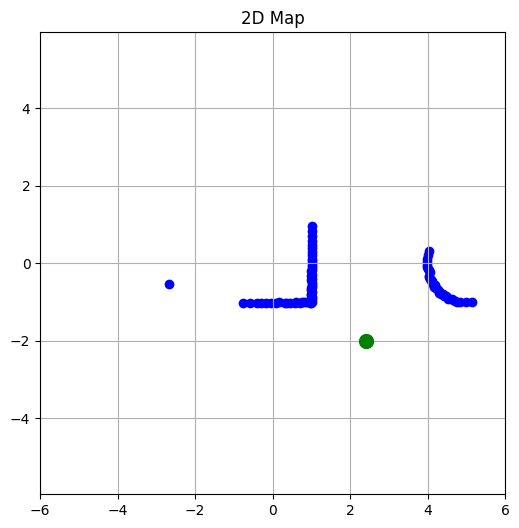

In [4]:
t=32*10 #5sec times number of samples/second
angle = np.linspace(-179, 180, num=360)

plt.figure()
plt.scatter(angle, Lidar_range[t], color='b')
plt.title('Lidar measurements')
plt.ylabel('r [m]')
plt.xlabel('$beta$ [degree]')
plt.grid();
plt.show()

#Build the cloud points in 2D plan
x_o, y_o = [], []
for i in range(len(Lidar_range[t])):
  if Lidar_range[t][i] > 0:
    x_o.append(px[t]+Lidar_range[t][i]*np.cos(angle[i]/180*np.pi))
    y_o.append(py[t]+Lidar_range[t][i]*np.sin(angle[i]/180*np.pi))

fig, ax = plt.subplots(figsize=(6,6))
ax.axis('equal')
xdim, ydim = 5, 5
plt.xlim(-xdim-1,xdim+1)
plt.ylim(-ydim-1,ydim+1)
plt.plot(px[t], py[t], 'g.', ms=20)  #position of the robot
plt.grid()

plt.scatter(x_o, y_o, color='b')
plt.title('2D Map');
plt.show()

# **Part 1: Classification of one object**

At this point, the goal is to classify only one object that could be a square or a circle at each LIDAR snapshot. To this end, it was performed a set of 4 experiments for each obstacle (alone) where in each experiment the robot travelled during $40\,s$ with a constant speed and constant direction (horizontal line segment from left to right) from the initial position $(p_x, p_y) = (-4, \bar y)$ to the final position $(p_x, p_y) = (4, \bar y)$, where $\bar y = -4, -3, -2, -1\, m$ \\
The obstacle (circle and square) were placed at the center of the origin $(0,0)$. \\
All the experiments were combined in a unique dataset and then randomly split into two datasets: the trainning data set (70%) and the testing data set (30%). The content of each data set are displayed next.

Note that there is an extra column (the label column) that indicates if the obstacle is a **circle (label 1)** or a **square (label 2)**.

**1.1**
Implement a **$k$-nearest neighbor ($k$-NN)** classifier that receives the parameter $k$, the sample to classify (that are the range measurements at one snapshot), and a set of labeled training data. \\
Do not use sklearn or similar packages (use the results of notebook #7).

In [5]:
"""Import python packages."""
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [6]:
"""Define euclidean distance and k-NN classifier functions."""
def EuclideanDistance(test, train):
    return [np.sqrt(sum((np.array(test) - np.array(observation))**2)) for observation in train]

def KNNclassifier(k, x, data, classes):
    dist = EuclideanDistance(x, data)
    ind = np.argsort(np.array(dist), axis=0)
    classes_sorted = classes[ind]
    c1 = 0
    c2 = 0
    for i in range(k):
        if classes_sorted[i] == 1:
            c1 += 1
        else:
            c2 += 1
    if c2 > c1:
        return 2
    else:
        return 1

**1.2**
Test the $k$-NN classifier for the `data_train.csv` set and for the `data_test.csv` set and obtain the respectively accuracy for $k=1,3,5,7,9$ \\
Note that accuracy is defined as 
$$acc = \frac{\#\text{correct predictions}}{\#\text{all predictions}} = \frac{TP+TN}{TP+TN+FP+FN}$$

where TP are the true positives, TN true negatives, FP false positives, and FN the fale negatives. 


In [7]:
"""Preprocess data."""
df_train = pd.read_csv('data_train.csv', index_col=0)
df_test = pd.read_csv('data_test.csv', index_col=0)
lidar_range_train = df_train.values[:, 2:362]
lidar_range_test = df_test.values[:, 2:362]
k_list = [1, 3, 5, 7, 9]
classes_train = df_train.values[:,-1]
classes_test = df_test.values[:, -1]

In [8]:
"""Classify test dataset using train dataset."""
classifications = np.zeros(shape=(len(lidar_range_test), len(k_list)))
for k in range(len(k_list)):
    for i in range(len(lidar_range_test)):
        classifications[i, k] = KNNclassifier(k, lidar_range_test[i], lidar_range_train, classes_train)

In [9]:
"""Calculate accuracy of classification for each k."""
accuracy_test = dict()
for k in range(len(k_list)):
    accuracy_test[k_list[k]] = sum(classifications[:,k] == classes_test)/len(classes_test)

print(accuracy_test)

{1: 0.5, 3: 1.0, 5: 0.99375, 7: 0.9947916666666666, 9: 0.9895833333333334}


**1.3**
Implement an Artificial Neural Network (ANN) of the type multi-layer perceptron (MLP) with
1. an input layer that receives the first 10 nonzero range measurements (for each snapshot);  
2. one hidden layer with 5 neurons with activation functions of the type ReLU (rectified linear unit);
3. an output layer with 1 neuron with a sigmoid activation function; 

4. a loss function of the type mean square error.

Train the ANN using the `data_train.csv` set. \\
**Do not use** PyTorch, TensorFlow or similar packages (check notebook #8). \\
**Tip:** It is important to shuffle the training data. You may get better results with non constant learning rate. A final loss below 0.05 is good!


In [10]:
"""Preprocess data."""
# Shuffle data arrays
array_train = np.array(df_train)
array_test = np.array(df_test)
np.random.shuffle(array_train)
np.random.shuffle(array_test)

lidar_range_train = array_train[:, 2:362]
lidar_range_test = array_test[:, 2:362]
classes_train = array_train[:,-1]
classes_test = array_test[:, -1]
classes_train[np.where(classes_train == 2.)] = np.float64(0.)
classes_test[np.where(classes_test == 2.)] = np.float64(0.)

# Arrays with 1st 10 non-zero measurements
def filter_10_nonzeros(a):
    diff = 10 - a[np.where(np.nan_to_num(a) != 0)].shape[0]
    if diff <= 0:
        return a[np.where(np.nan_to_num(a) != 0)][0:10]
    else:
        return np.concatenate((a[np.where(np.nan_to_num(a) != 0)], np.zeros(shape=(diff,))))

lidar_test_10 = np.apply_along_axis(filter_10_nonzeros, 1, lidar_range_test)
lidar_train_10 = np.apply_along_axis(filter_10_nonzeros, 1, lidar_range_train)

In [29]:
"""Train ANN."""
def mse_loss(y_true, y_pred):
    return((y_true - y_pred)**2).mean()

def relu(x):
    return np.maximum(x, 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu_derivative(x):
    if x > 0:
        return 1.
    elif x <= 0:
        return 0.

def sigmoid_derivative(x):
    fx = sigmoid(x)
    return fx * (1 - fx)

class NeuralNetwork:
    def __init__(self) -> None:
        # biases
        self.biases = np.random.uniform(low=0., high=0.05, size=(6,))
        # weights
        self.weights = np.random.uniform(low=0., high=0.05, size=(55,))

    def feedforward(self, x):
        self.total_h1 = np.dot(x, self.weights[0:10]) + self.biases[0]
        self.total_h2 = np.dot(x, self.weights[10:20]) + self.biases[1]
        self.total_h3 = np.dot(x, self.weights[20:30]) + self.biases[2]
        self.total_h4 = np.dot(x, self.weights[30:40]) + self.biases[3]
        self.total_h5 = np.dot(x, self.weights[40:50]) + self.biases[4]
        self.output_h1 = relu(self.total_h1)
        self.output_h2 = relu(self.total_h2)
        self.output_h3 = relu(self.total_h3)
        self.output_h4 = relu(self.total_h4)
        self.output_h5 = relu(self.total_h5)

        self.total_o1 = np.dot(
            np.array([self.output_h1, self.output_h2, self.output_h3, self.output_h4, self.output_h5]),
            self.weights[50:55]
        ) + self.biases[5]
        self.output_o1 = sigmoid(self.total_o1)

        return self.output_o1
    
    def train(self, input, y_trues, learning_rate=0.005, epochs=1501):
        loss_prev = 10000
        for epoch in range(epochs):
            for x, y_true in zip(input, y_trues):
                y_pred = self.feedforward(x)

                # Backpropagation ###########################
                dl_dypred = -2 * (y_true - y_pred)

                # output layer / neuron o1
                dypred_dw51 = self.output_h1 * sigmoid_derivative(self.total_o1)
                dypred_dw52 = self.output_h2 * sigmoid_derivative(self.total_o1)
                dypred_dw53 = self.output_h3 * sigmoid_derivative(self.total_o1)
                dypred_dw54 = self.output_h4 * sigmoid_derivative(self.total_o1)
                dypred_dw55 = self.output_h5 * sigmoid_derivative(self.total_o1)
                dypred_db5 = sigmoid_derivative(self.total_o1)
                dypred_dh1 = self.weights[50] * sigmoid_derivative(self.total_o1)
                dypred_dh2 = self.weights[51] * sigmoid_derivative(self.total_o1)
                dypred_dh3 = self.weights[52] * sigmoid_derivative(self.total_o1)
                dypred_dh4 = self.weights[53] * sigmoid_derivative(self.total_o1)
                dypred_dh5 = self.weights[54] * sigmoid_derivative(self.total_o1)

                # hidden layer / neuron h1
                dh1_db1 = relu_derivative(self.total_h1)
                dh1_dw1 = x[0] * relu_derivative(self.total_h1)
                dh1_dw2 = x[1] * relu_derivative(self.total_h1)
                dh1_dw3 = x[2] * relu_derivative(self.total_h1)
                dh1_dw4 = x[3] * relu_derivative(self.total_h1)
                dh1_dw5 = x[4] * relu_derivative(self.total_h1)
                dh1_dw6 = x[5] * relu_derivative(self.total_h1)
                dh1_dw7 = x[6] * relu_derivative(self.total_h1)
                dh1_dw8 = x[7] * relu_derivative(self.total_h1)
                dh1_dw9 = x[8] * relu_derivative(self.total_h1)
                dh1_dw10 = x[9] * relu_derivative(self.total_h1)

                # hidden layer / neuron h2
                dh2_db2 = relu_derivative(self.total_h2)
                dh2_dw11 = x[0] * relu_derivative(self.total_h2)
                dh2_dw12 = x[1] * relu_derivative(self.total_h2)
                dh2_dw13 = x[2] * relu_derivative(self.total_h2)
                dh2_dw14 = x[3] * relu_derivative(self.total_h2)
                dh2_dw15 = x[4] * relu_derivative(self.total_h2)
                dh2_dw16 = x[5] * relu_derivative(self.total_h2)
                dh2_dw17 = x[6] * relu_derivative(self.total_h2)
                dh2_dw18 = x[7] * relu_derivative(self.total_h2)
                dh2_dw19 = x[8] * relu_derivative(self.total_h2)
                dh2_dw20 = x[9] * relu_derivative(self.total_h2)

                # hidden layer / neuron h3
                dh3_db3 = relu_derivative(self.total_h3)
                dh3_dw21 = x[0] * relu_derivative(self.total_h3)
                dh3_dw22 = x[1] * relu_derivative(self.total_h3)
                dh3_dw23 = x[2] * relu_derivative(self.total_h3)
                dh3_dw24 = x[3] * relu_derivative(self.total_h3)
                dh3_dw25 = x[4] * relu_derivative(self.total_h3)
                dh3_dw26 = x[5] * relu_derivative(self.total_h3)
                dh3_dw27 = x[6] * relu_derivative(self.total_h3)
                dh3_dw28 = x[7] * relu_derivative(self.total_h3)
                dh3_dw29 = x[8] * relu_derivative(self.total_h3)
                dh3_dw30 = x[9] * relu_derivative(self.total_h3)

                # hidden layer / neuron h4
                dh4_db4 = relu_derivative(self.total_h4)
                dh4_dw31 = x[0] * relu_derivative(self.total_h4)
                dh4_dw32 = x[1] * relu_derivative(self.total_h4)
                dh4_dw33 = x[2] * relu_derivative(self.total_h4)
                dh4_dw34 = x[3] * relu_derivative(self.total_h4)
                dh4_dw35 = x[4] * relu_derivative(self.total_h4)
                dh4_dw36 = x[5] * relu_derivative(self.total_h4)
                dh4_dw37 = x[6] * relu_derivative(self.total_h4)
                dh4_dw38 = x[7] * relu_derivative(self.total_h4)
                dh4_dw39 = x[8] * relu_derivative(self.total_h4)
                dh4_dw40 = x[9] * relu_derivative(self.total_h4)

                # hidden layer / neuron h5
                dh5_db5 = relu_derivative(self.total_h5)
                dh5_dw41 = x[0] * relu_derivative(self.total_h5)
                dh5_dw42 = x[1] * relu_derivative(self.total_h5)
                dh5_dw43 = x[2] * relu_derivative(self.total_h5)
                dh5_dw44 = x[3] * relu_derivative(self.total_h5)
                dh5_dw45 = x[4] * relu_derivative(self.total_h5)
                dh5_dw46 = x[5] * relu_derivative(self.total_h5)
                dh5_dw47 = x[6] * relu_derivative(self.total_h5)
                dh5_dw48 = x[7] * relu_derivative(self.total_h5)
                dh5_dw49 = x[8] * relu_derivative(self.total_h5)
                dh5_dw50 = x[9] * relu_derivative(self.total_h5)

                #######################################################

                # Gradient Descent
                # Output layer / neuron o1
                self.weights[50] -= learning_rate * dl_dypred * dypred_dw51
                self.weights[51] -= learning_rate * dl_dypred * dypred_dw52
                self.weights[52] -= learning_rate * dl_dypred * dypred_dw53
                self.weights[53] -= learning_rate * dl_dypred * dypred_dw54
                self.weights[54] -= learning_rate * dl_dypred * dypred_dw55
                self.biases[4] -= learning_rate * dl_dypred * dypred_db5

                # Hidden layer / neuron h1
                self.weights[0] -= learning_rate * dl_dypred * dypred_dh1 * dh1_dw1
                self.weights[1] -= learning_rate * dl_dypred * dypred_dh1 * dh1_dw2
                self.weights[2] -= learning_rate * dl_dypred * dypred_dh1 * dh1_dw3
                self.weights[3] -= learning_rate * dl_dypred * dypred_dh1 * dh1_dw4
                self.weights[4] -= learning_rate * dl_dypred * dypred_dh1 * dh1_dw5
                self.weights[5] -= learning_rate * dl_dypred * dypred_dh1 * dh1_dw6
                self.weights[6] -= learning_rate * dl_dypred * dypred_dh1 * dh1_dw7
                self.weights[7] -= learning_rate * dl_dypred * dypred_dh1 * dh1_dw8
                self.weights[8] -= learning_rate * dl_dypred * dypred_dh1 * dh1_dw9
                self.weights[9] -= learning_rate * dl_dypred * dypred_dh1 * dh1_dw10
                self.biases[0] -= learning_rate * dl_dypred * dypred_dh1 * dh1_db1

                # Hidden layer / neuron h2
                self.weights[10] -= learning_rate * dl_dypred * dypred_dh2 * dh2_dw11
                self.weights[11] -= learning_rate * dl_dypred * dypred_dh2 * dh2_dw12
                self.weights[12] -= learning_rate * dl_dypred * dypred_dh2 * dh2_dw13
                self.weights[13] -= learning_rate * dl_dypred * dypred_dh2 * dh2_dw14
                self.weights[14] -= learning_rate * dl_dypred * dypred_dh2 * dh2_dw15
                self.weights[15] -= learning_rate * dl_dypred * dypred_dh2 * dh2_dw16
                self.weights[16] -= learning_rate * dl_dypred * dypred_dh2 * dh2_dw17
                self.weights[17] -= learning_rate * dl_dypred * dypred_dh2 * dh2_dw18
                self.weights[18] -= learning_rate * dl_dypred * dypred_dh2 * dh2_dw19
                self.weights[19] -= learning_rate * dl_dypred * dypred_dh2 * dh2_dw20
                self.biases[1] -= learning_rate * dl_dypred * dypred_dh2 * dh2_db2

                # Hidden layer / neuron h3
                self.weights[20] -= learning_rate * dl_dypred * dypred_dh3 * dh3_dw21
                self.weights[21] -= learning_rate * dl_dypred * dypred_dh3 * dh3_dw22
                self.weights[22] -= learning_rate * dl_dypred * dypred_dh3 * dh3_dw23
                self.weights[23] -= learning_rate * dl_dypred * dypred_dh3 * dh3_dw24
                self.weights[24] -= learning_rate * dl_dypred * dypred_dh3 * dh3_dw25
                self.weights[25] -= learning_rate * dl_dypred * dypred_dh3 * dh3_dw26
                self.weights[26] -= learning_rate * dl_dypred * dypred_dh3 * dh3_dw27
                self.weights[27] -= learning_rate * dl_dypred * dypred_dh3 * dh3_dw28
                self.weights[28] -= learning_rate * dl_dypred * dypred_dh3 * dh3_dw29
                self.weights[29] -= learning_rate * dl_dypred * dypred_dh3 * dh3_dw30
                self.biases[2] -= learning_rate * dl_dypred * dypred_dh3 * dh3_db3
            
                # Hidden layer / neuron h4
                self.weights[30] -= learning_rate * dl_dypred * dypred_dh4 * dh4_dw31
                self.weights[31] -= learning_rate * dl_dypred * dypred_dh4 * dh4_dw32
                self.weights[32] -= learning_rate * dl_dypred * dypred_dh4 * dh4_dw33
                self.weights[33] -= learning_rate * dl_dypred * dypred_dh4 * dh4_dw34
                self.weights[34] -= learning_rate * dl_dypred * dypred_dh4 * dh4_dw35
                self.weights[35] -= learning_rate * dl_dypred * dypred_dh4 * dh4_dw36
                self.weights[36] -= learning_rate * dl_dypred * dypred_dh4 * dh4_dw37
                self.weights[37] -= learning_rate * dl_dypred * dypred_dh4 * dh4_dw38
                self.weights[38] -= learning_rate * dl_dypred * dypred_dh4 * dh4_dw39
                self.weights[39] -= learning_rate * dl_dypred * dypred_dh4 * dh4_dw40
                self.biases[3] -= learning_rate * dl_dypred * dypred_dh4 * dh4_db4

                # Hidden layer / neuron h5
                self.weights[40] -= learning_rate * dl_dypred * dypred_dh5 * dh5_dw41
                self.weights[41] -= learning_rate * dl_dypred * dypred_dh5 * dh5_dw42
                self.weights[42] -= learning_rate * dl_dypred * dypred_dh5 * dh5_dw43
                self.weights[43] -= learning_rate * dl_dypred * dypred_dh5 * dh5_dw44
                self.weights[44] -= learning_rate * dl_dypred * dypred_dh5 * dh5_dw45
                self.weights[45] -= learning_rate * dl_dypred * dypred_dh5 * dh5_dw46
                self.weights[46] -= learning_rate * dl_dypred * dypred_dh5 * dh5_dw47
                self.weights[47] -= learning_rate * dl_dypred * dypred_dh5 * dh5_dw48
                self.weights[48] -= learning_rate * dl_dypred * dypred_dh5 * dh5_dw49
                self.weights[49] -= learning_rate * dl_dypred * dypred_dh5 * dh5_dw50
                self.biases[4] -= learning_rate * dl_dypred * dypred_dh5 * dh5_db5

            # Performance assessment
            if epoch % 5 == 0:
                y_preds = np.apply_along_axis(self.feedforward, 1, input)
                loss = mse_loss(y_trues, y_preds)
                if epoch % 100 == 0:
                    print("Epoch %d | Loss: %.4f" % (epoch, loss))
                if loss > loss_prev:  #if loss did not decrease, let's decrease the learn_rate
                    if learning_rate > 0.0001:
                        learning_rate = learning_rate*.75  #decrease 90% of the previous value
                    print("New learning rate equals %6.5f at epoch %d" % (learning_rate, epoch))
                loss_prev = loss

model = NeuralNetwork()
model.train(lidar_train_10, classes_train)

Epoch 0 | Loss: 0.2498
Epoch 100 | Loss: 0.1297
New learning rate equals 0.00375 at epoch 110
New learning rate equals 0.00281 at epoch 125
New learning rate equals 0.00211 at epoch 135
New learning rate equals 0.00158 at epoch 165
Epoch 200 | Loss: 0.0926
New learning rate equals 0.00119 at epoch 215
Epoch 300 | Loss: 0.0782
New learning rate equals 0.00089 at epoch 310
New learning rate equals 0.00067 at epoch 345
Epoch 400 | Loss: 0.0705
New learning rate equals 0.00050 at epoch 455
Epoch 500 | Loss: 0.0677
New learning rate equals 0.00038 at epoch 555
Epoch 600 | Loss: 0.0653
Epoch 700 | Loss: 0.0644
Epoch 800 | Loss: 0.0635
Epoch 900 | Loss: 0.0626
Epoch 1000 | Loss: 0.0618
New learning rate equals 0.00028 at epoch 1090
Epoch 1100 | Loss: 0.0597
Epoch 1200 | Loss: 0.0592
Epoch 1300 | Loss: 0.0586
New learning rate equals 0.00021 at epoch 1390
Epoch 1400 | Loss: 0.0575
Epoch 1500 | Loss: 0.0571


**1.4**
Test the ANN classifier for the `data_train.csv` set and for the `data_test.csv` set and obtain the respectively accuracy. Write in a brief sentence of the main conclusions about the classifiers (k-NN and ANN) until this point.

In [30]:
"""Test ANN. Classify test dataset."""
classifications_ANN_test = np.zeros(shape=(len(lidar_test_10)))
for i in range(lidar_test_10.shape[0]):
    classifications_ANN_test[i] = model.feedforward(lidar_test_10[i])

# Set classifications to discrete values.
classifications_ANN_test = np.where(classifications_ANN_test >= 0.5, 1., 0.)

# Calculate accuracy.
accuracy_ANN_test = sum(classifications_ANN_test == classes_test)/len(classes_test)
print(accuracy_ANN_test)

0.9239583333333333


In [31]:
"""Test ANN. Classify train dataset."""
classifications_ANN_train = np.zeros(shape=(len(lidar_train_10)))
for i in range(lidar_train_10.shape[0]):
    classifications_ANN_train[i] = model.feedforward(lidar_train_10[i])

# Set classifications to discrete values.
classifications_ANN_train = np.where(classifications_ANN_train >= 0.5, 1., 0.)

# Calculate accuracy.
accuracy_ANN_train = sum(classifications_ANN_train == classes_train)/len(classes_train)
print(accuracy_ANN_train)

0.9383928571428571


### Part 1: Brief conclusion
Comparing the k-NN classifier with the ANN classifier, it's possible to see that the k-NN performed better for the proposed implementation, attaining a better accuracy with less arbitrarily chosen parameters. The ANN is more versatile though, and could possibly perform better with more training; better chosen learning rate and initial conditions on weights and biases.

# **Part 2: Classification of two objects**

We would like now to use the previous ANN classifier to the data in `data_test2obs.csv` that may have two objects at the same snapshot. The idea is to before send the range measurements to the classifier, apply first a k-means at each snapshot to separate the data into two sub-sets such that each sub-set only contains data of one object. Then, send each subset of data to the ANN classifier.

**2.1**
Implement the k-means algorithm and test it for two snapshots **converted to the 2D map** (that is, the input data for the k-means is the 2D map) of the dataset `data_test2obs.csv` for 
1. $t=1\,s$ (which has only one object) and 
2. for $t=32\,s$ (which has 2 objects). 

What can you conclude? \\
Do not use sklearn or similar packages (use the results of notebook #10).


In [14]:
"""Preprocess data."""
def filter_nonzeros(a):
    return a[np.where(a != 0)]
df_test2obs = pd.read_csv('data_test2obs.csv', index_col=0)
Lidar_range = df_test2obs.iloc[:, np.arange(2,362,1)].values
px = df_test2obs["px"].values
py = df_test2obs["py"].values
t1=1*10 #1sec times number of samples/second
t2=32*10 #5sec times number of samples/second
angle = np.linspace(-179, 180, num=360)
# Clean outliers greater than 5m
Lidar_range[np.where(Lidar_range > 5.0)] = 0
# Build the cloud points in 2D plan
xy = np.zeros(shape=(*Lidar_range.shape, 2))
for t in range(len(Lidar_range)):
    for i in range(len(Lidar_range[t])):
        if Lidar_range[t][i] > 0:
            xy[t][i][0] = px[t]+Lidar_range[t][i]*np.cos(angle[i]/180*np.pi)
            xy[t][i][1] = py[t]+Lidar_range[t][i]*np.sin(angle[i]/180*np.pi)
xy1 = xy[t1, :, :]
xy2 = xy[t2, :, :]
xy1 = np.apply_along_axis(filter_nonzeros, 0, xy1)
xy2 = np.apply_along_axis(filter_nonzeros, 0, xy2)

In [15]:
"""K-means method."""
def k_means(X, k):
    cluster = np.zeros(shape=X.shape[0])
    centroids_0 = []
    for c in range(k):
        centroids_0.append([np.random.uniform(low=min(X[:, 0]), high=max(X[:, 0])), np.random.uniform(min(X[:, 1]), max(X[:, 1]))])

    diff = 1
    centroids = centroids_0
    centroids_list = [centroids]

    while diff:
        for i, point in enumerate(X):
            min_distance = np.inf
            for j, centroid in enumerate(centroids):
                distance = np.sqrt((centroid[0] - point[0]) ** 2 + (centroid[1] - point[1]) ** 2)
                if min_distance > distance:
                    min_distance = distance
                    cluster[i] = j
        total = np.zeros(shape=(k, 2))
        count = np.zeros(shape=(k))
        for i, point in enumerate(X):
            total[int(cluster[i])] += X[i]
            count[int(cluster[i])] += 1
        new_centroids = np.zeros(shape=(k, 2))
        for l in range(k):
            if count[l] > 0:
                new_centroids[l] = total[l] / count[l]
            else:
                new_centroids[l] = [np.random.uniform(min(X[:, 0]), max(X[:, 0])), np.random.uniform(min(X[:, 1]), max(X[:, 1]))]
        if np.count_nonzero(centroids - new_centroids) == 0:
            diff = 0
        else: 
            centroids = new_centroids
            centroids_list.append(centroids)

    return centroids, cluster

In [16]:
"""Assign points to cluster."""
centroids1, cluster1 = k_means(xy1, 1)
centroids2, cluster2 = k_means(xy2, 2)

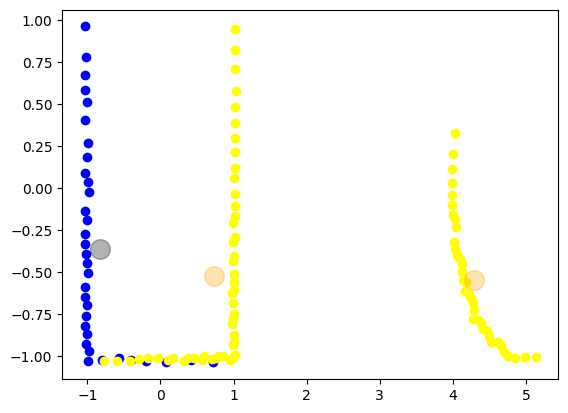

In [17]:
"""Print clusters and centroids for t = 1s and t = 32s."""
plt.scatter(xy1[:, 0], xy1[:, 1], c='blue')
plt.scatter(xy2[:, 0], xy2[:, 1], c='yellow')
plt.scatter(centroids1[:, 0], centroids1[:, 1], c='black', s=200, alpha=0.3)
plt.scatter(centroids2[:, 0], centroids2[:, 1], c='orange', s=200, alpha=0.3)
plt.show()

**2.2**
Using the previous results, 
1. implement a method to automatically identify for each snapshot if it has 1 or 2 objects;
2. build a new test set with all the data in `data_test2obs.csv`, but now the new test set only has 1 object in each snapshot (and therefore this data set has more lines);
3. test this new data set using the ANN classifier.

Plot the position of the robot and the classified objects for some snapshots. What are the main conclusions?

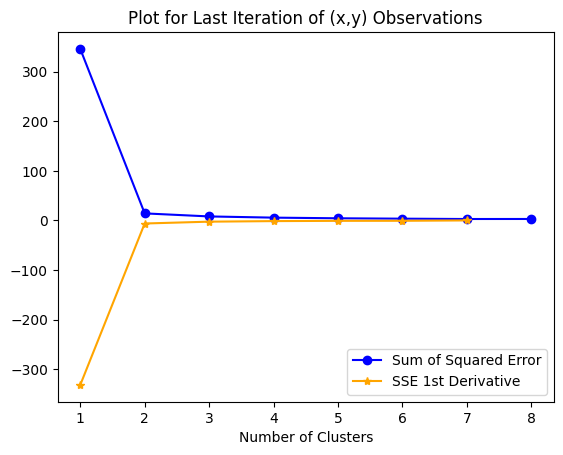

In [18]:
"""Estimate best number of clusters."""
def SSE(X, centroids, cluster):
    total = 0
    for i, point in enumerate(X):
        total += np.sqrt((centroids[int(cluster[i]), 0] - point[0]) ** 2 + (centroids[int(cluster[i]), 1] - point[1]) ** 2)
    return total

def find_bestk(derivatives, derivatives_range, threshold):
    bestk = 0
    for i in reversed(derivatives_range):
        if derivatives[i-1] < threshold:
            bestk = i+1
            break
    if bestk == 0:
        return 1
    elif bestk > 2:
        return 2
    return bestk

bestk = []
k_range = range(1, 9)
threshold = -100
for t in range(xy.shape[0]):
    cost_list = []
    for k in k_range:
        centroids, cluster = k_means(xy[t, :, :], k)
        cost = SSE(xy[t, :, :], centroids, cluster)
        cost_list.append(cost)
    derivatives = []
    derivatives_range = range(1, max(k_range))
    for i in derivatives_range:
        derivatives.append(cost_list[i] - cost_list[i-1])
    bestk.append(find_bestk(derivatives, derivatives_range, threshold))

plt.plot(k_range, cost_list, c='blue', marker='o')
plt.plot(derivatives_range, derivatives, c='orange', marker='*')
plt.legend(["Sum of Squared Error", "SSE 1st Derivative"], loc ="lower right")
plt.title("Plot for Last Iteration of (x,y) Observations")
plt.xlabel("Number of Clusters")
plt.show()

In [19]:
"""Build new dataset with one object for each snapshot."""
xy2_list = []
for t in range(xy.shape[0]):
    cluster = k_means(xy[t, :, :], bestk[t])[1]
    for k in range(0, bestk[t-250]):
        xy2_sublist = []
        for feature in range(0, xy[t, :, :].shape[0]):
            if k == 0.:
                key = int(not(cluster[feature]))
            elif k == 1.:
                key = int(cluster[feature])
            xy2_sublist.append(xy[t, :, :][feature] * key)
        xy2_list.append(np.array(xy2_sublist))
xy_full = np.array(xy2_list)

In [20]:
# Get the first 10 non-zero lidar measurement approx.
lidar_range_full = np.zeros(shape=(xy_full.shape[0:2]))
for t in range(xy_full.shape[0]):
    for i in range(xy_full.shape[1]):
        lidar_range_full[int(t)][int(i)] = (xy_full[t, i, 0] / np.cos(angle[i]/180*np.pi)) + (xy_full[t, i, 1] / np.sin(angle[i]/180*np.pi))

In [21]:
lidar_nonzeros = np.apply_along_axis(filter_10_nonzeros, 1, lidar_range_full)

In [22]:
"""Classify data using ANN."""
classifications_ANN_full = np.zeros(shape=(len(lidar_nonzeros)))
for i in range(lidar_nonzeros.shape[0]):
    classifications_ANN_full[i] = model.feedforward(lidar_nonzeros[i])
# Set classifications to discrete values.
classifications_ANN_full = np.where(classifications_ANN_full >= 0.5, 1., 0.)